In [1]:
import numpy as np
import pandas as pd

import logistic_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

np.random.seed(44) # for comparison of results

# Comparison of different optimization methods for logistic regression

In the following notebook, we will compare different optimization methods for logistic regression. We will use one generated dataseta along with many real datasets. We will compare the following optimization methods:
- IWLS (Iteratively Reweighted Least Squares)
- SGD (Stochastic Gradient Descent)
- ADAM (Adaptive Moment Estimation)

We will also compare the performance of the optimization methods using interactions between features and without.

The parameters of the optimization methods are choosen to be default for each method:

## Stopping criterion

To make a comparison fair, we propose the same stopping rule for each algorithm.
We will stop the optimization when the values of the gradient are less than 1^{-3} or when the number of iterations is greater than 100.

CONSIDER DIFFERENT STOPPING RULES

In [20]:
def compare_methods(X, y, algorithms = ["iwls", "sgd", "adam"], k = 5, test_size = 0.2, interaction = False):
    balanced_accuracies = {}
    interaction_opt = [False]
    if interaction:
        interaction_opt.append(True)

    for alg in algorithms:
        balanced_accuracies[alg] = []
        
        print(f"Using algorithm: {alg}" + (" with interactions" if interaction else ""))
        for inter in interaction_opt:
            alg_name = alg + ("_inter" if inter else "")
            for i in range(k):
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
                model = logistic_regression.LogisticRegressor(descent_algorithm = alg, include_interactions = inter)
                model.fit(X_train, y_train, max_num_epoch = 100, tolerance=1e-3)
                balanced_accuracies[alg].append(model.balanced_accuracy(X_test, y_test))
                print(f"Balanced accuracy: {balanced_accuracies[alg_name][-1]}")
            print(f"Mean accuracy: {np.mean(balanced_accuracies[alg_name])}")
    balanced_accuracies = pd.DataFrame(balanced_accuracies)
    return balanced_accuracies

## Datasets

### artificial data

In [21]:
import numpy as np
from scipy.special import expit as sigmoid
n = 1000

a = 10

# Generate y observations from the binomial distribution
y = np.random.binomial(1, 0.5, size=n)

true_beta = np.array([5, 3])

X = np.random.normal(size = (n, 2))

y = np.random.binomial(1, sigmoid(X @ true_beta))

np.mean(y)

0.488

In [22]:
df = compare_methods(X, y)

Using algorithm: iwls
Balanced accuracy: 0.9150660264105642
Balanced accuracy: 0.8956582633053222
Balanced accuracy: 0.8896025692492975
Balanced accuracy: 0.9138522028430285
Balanced accuracy: 0.9046474358974359
Mean accuracy: 0.9037652995411296
Using algorithm: sgd
Balanced accuracy: 0.9058623449379752
Balanced accuracy: 0.9293717486994798
Balanced accuracy: 0.9121212121212121
Balanced accuracy: 0.9091636654661864
Balanced accuracy: 0.9211614073999395
Mean accuracy: 0.9155360757249585
Using algorithm: adam
Balanced accuracy: 0.930172068827531
Balanced accuracy: 0.92
Balanced accuracy: 0.9426561392853527
Balanced accuracy: 0.8780623046678093
Balanced accuracy: 0.9210950080515299
Mean accuracy: 0.9183971041664446


<Axes: >

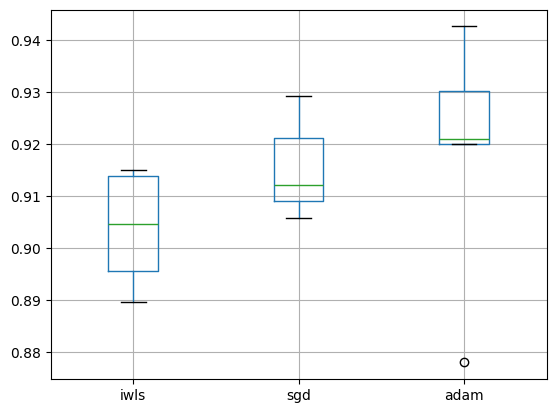

In [23]:
df.boxplot()

# Aids

In [3]:
aids = pd.read_csv('data/aids.csv')

y = aids['target']
X = aids.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [4]:
compare_methods(X, y)

Using algorithm: iwls


LinAlgError: Singular matrix

In [4]:
lr = logistic_regression.LogisticRegressor(descent_algorithm="sgd")

lr.fit(X_train, y_train, max_num_epoch=100)

y_pred = lr.predict(X_test)
lr.confusion_matrix(X_test, y_test)

IndexError: tuple index out of range

In [7]:
X_test.columns

Index(['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof',
       'oprior', 'z30', 'preanti', 'race', 'gender', 'symptom', 'treat',
       'offtrt', 'cd40', 'cd420', 'cd80', 'cd820'],
      dtype='object')

In [8]:
sklearn_lr = LogisticRegression(max_iter=10000, tol=1e-3, solver='lbfgs')
sklearn_lr.fit(X, y)
sklearn_lr.score(X, y)
y_pred = sklearn_lr.predict(X)

In [9]:
print(f"Our implementation\n{lr.confusion_matrix(X, y)}")
print(f"Sklearn implementation\n{confusion_matrix(y, y_pred)}")

Our implementation
[[ 182   73]
 [ 339 1545]]
Sklearn implementation
[[1531   87]
 [ 190  331]]


In [12]:
print(f"Accuracy of our implementation: {lr.accuracy(X_test, y_test)}")
print(f"Accuracy of sklearn implementation: {sklearn_lr.score(X_test, y_test)}")

Accuracy of our implementation: 0.8130841121495327
Accuracy of sklearn implementation: 0.8808411214953271
